# Nonparametric Differential Equations (npde)

This document describes how to use the software implementation of our **npsde** (nonparametric stochastic differential equations) model. The implementation is in python3.5 and requires __[TensorFlow(1.6.0+)](https://www.tensorflow.org/)__ and __[GPflow(1.1+)](https://github.com/GPflow/GPflow)__. To learn more about the model, __[here](https://arxiv.org/abs/1807.05748)__ is a link to the our paper to be presented in MLSP in September 2018. This repository also overrides the MATLAB implementation of **npODE** model for learning ordinary differential equations (__[here](http://proceedings.mlr.press/v80/heinonen18a/heinonen18a.pdf)__ is the npODE ICML 2018 paper and __[here](https://github.com/cagatayyildiz/npode)__ is the old MATLAB implementation).

&nbsp;

**Notebook Sections**

The notebook consists of three sections, each containing an example fit where the underlying dynamics are governed by an ODE, SDE with constant diffusion, and SDE with state dependent diffusion. Van der Pol (VDP) oscillator, whose dynamics are given by equations below, is used as the running example:
\begin{align*}
\frac{dx_1}{dt} = x_2 \qquad \qquad \frac{dx_2}{dt} &= (1-x_1^2) x_2 - x_1 
\end{align*}
In examples below, true constant diffusion is equal to 0.2 and the state dependent diffusion function is given by $g(x)=3\mathcal{N}(x;[-2,0],0.5I)$. The model is completely unaware of the dynamics, and infers the dynamics by placing Gaussian process priors over the drift and diffusion functions and computing the posterior.

&nbsp;

**Main Functions**

There are three main python functions that provide an easy-to-use interface to the model implementation:
 * ```npde_fit``` -  fits the model (ODE/SDE) to the input data and observed time points  
 * `predict` - a class function that predicts signals given a `npde` model that stores the learned SDE dynamics, an initial value and observed time points   
 * `sample` - a class function that draws samples from a learned SDE system signals given the same input in `predict` function

&nbsp;

**For Better Performance**

The quality of the fit relies on many factors including the width of the inducing point grid `W`, lengthscales `ell`, learning rate `eta`, number of optimization steps `num_iter` and number of samples `Nw` used for optimization in SDEs. Few notes about enhancing the performance: 
 * In general, a denser inducing point grid and more samples for SDEs are better - the higher `W` and `Nw`, the better. 
 * Learning rate must always be carefully tuned for every problem and even data set.
 * Higher lengthscale values result in smoother trajectories. Although optimized, we reserve it for model selection. For example in modeling constant diffusions, lengthscale of the diffusion function must be high, e.g., $10^5$. It is also a good idea to perform the optimization several times over a grid of lengthscales. For instance, a good grid in case of VDP oscillator with `W=5` would be `linspace(0.75,4,10`).
 * It should also be noted that `W` and `ell` should be tuned together carefully. In general, if one is increased, then the other should be decreased.

## Preparing the Environment

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.InteractiveSession()

import numpy as np
from utils import gen_data
from npde_helper import npde_fit

## 1. ODE

### Data Generation

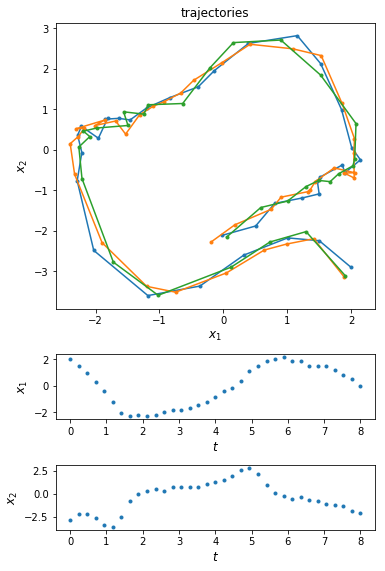

In [2]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tend=8, nstd=0.1)

###  Inference

Model being initialized...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         263.395
             100         101.015
             200          57.412
             300          36.959
             400          29.540
             500          39.548
Optimization ends.
Plotting...
noise variance:        [0.00569295 0.01308237]
signal variance:       1.5543774391601328
lengthscales:          [0.81543881 1.26242647]


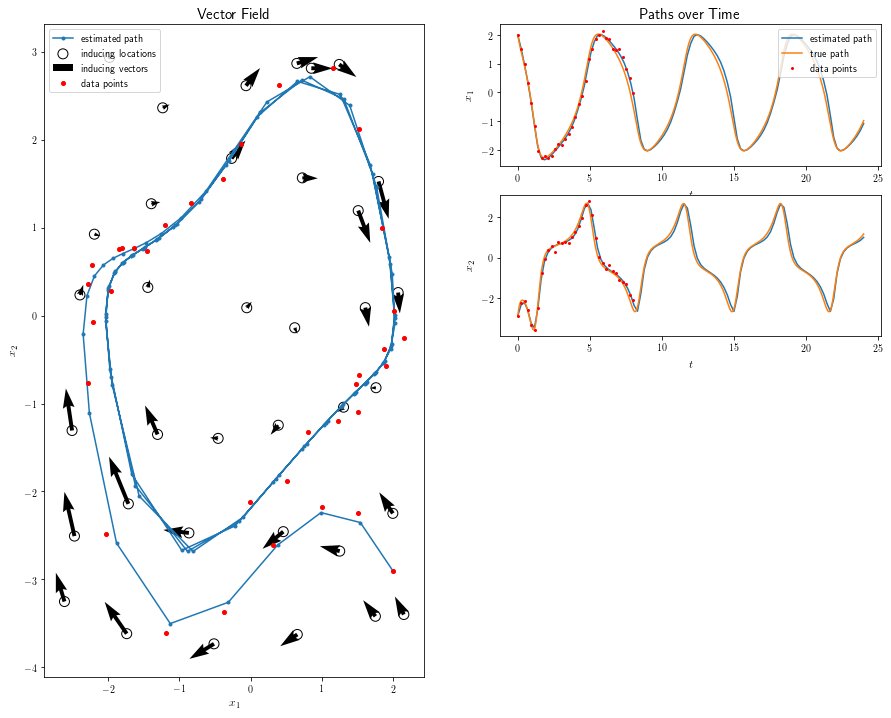

In [3]:
npde = npde_fit(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id",
                num_iter=500, print_int=100, eta=0.02, plot_=True)

## 2. SDE with Constant Diffusion

### Data Generation

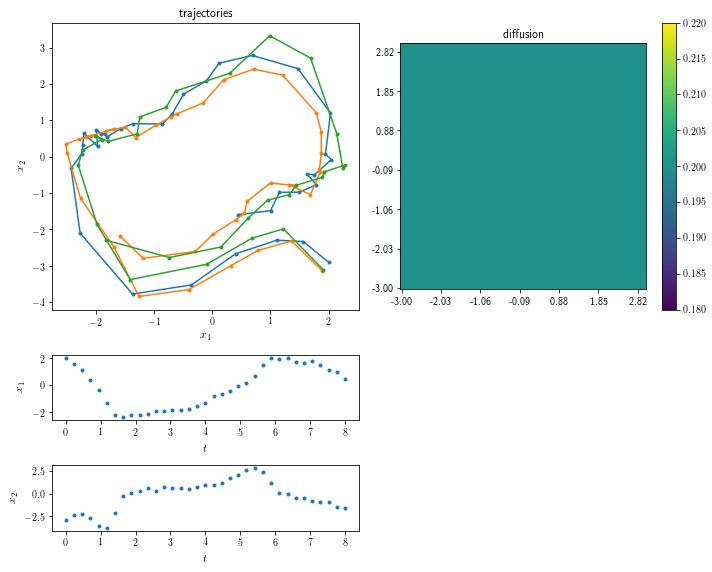

In [4]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[35,40,30], tend=8, nstd=0.1)

### Inference

Model being initialized...
(50, 35, 2)
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         374.191
             100         206.433
             200         183.618
             300         196.814
             400         152.618
             500         160.210
Optimization ends.
Plotting...
noise variance:        [0.01688049 0.03194111]
signal variance:       1.5271372148809041
lengthscales:          [0.83605293 1.07443012]
diff signal variance:  0.7682719768427619
diff lengthscales:     [100000.04313852]


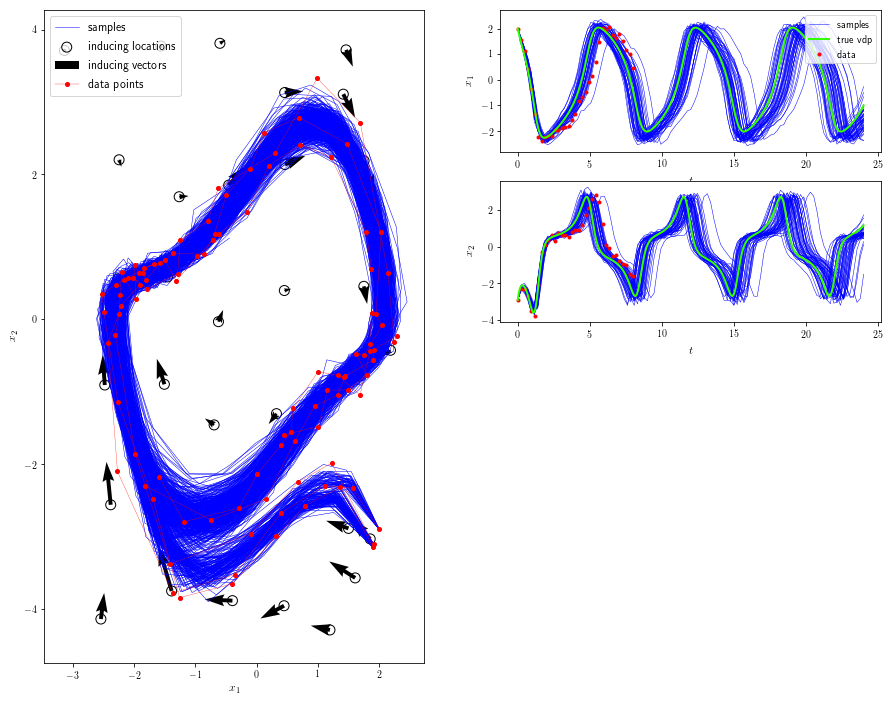

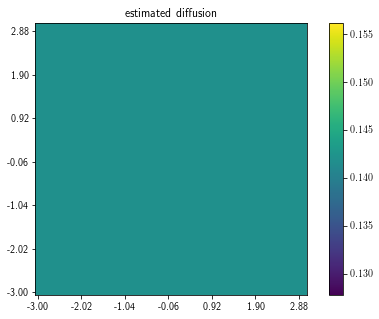

In [5]:
npde = npde_fit(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ktype="id",
                Nw=50, num_iter=500, print_int=100, eta=0.02, plot_=True)

### Predictions

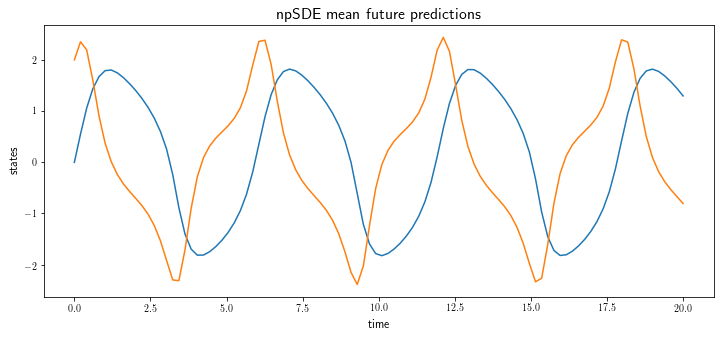

In [6]:
x0 = [0,2]
t = np.linspace(0,20,100)
path = npde.predict(x0,t)
path = sess.run(path)

plt.figure(figsize=(12,5))
plt.plot(t,path)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE mean future predictions',fontsize=16);

### Sampling

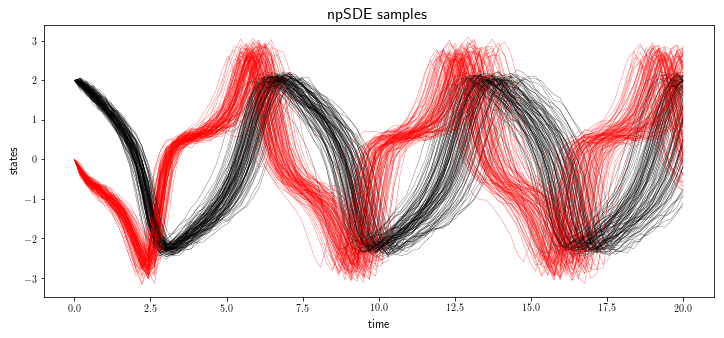

In [7]:
x0 = [2,0]
t = np.linspace(0,20,100)
Nw = 100
samples = npde.sample(Nw=100,x0=x0,t=t)
samples = sess.run(samples)

plt.figure(figsize=(12,5))
for i in range(Nw):
    plt.plot(t,samples[i,:,0],'-k',linewidth=0.25)
    plt.plot(t,samples[i,:,1],'-r',linewidth=0.25)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE samples',fontsize=16);

## 3. SDE with State Dependent Diffusion

### Data Generation

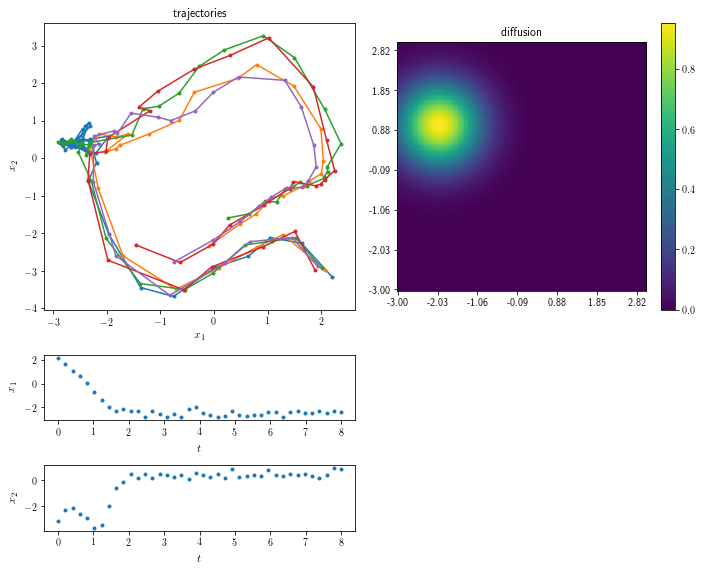

In [8]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[40,30,40,30,30], tend=8, nstd=0.1)

### Inference

Model being initialized...
(200, 40, 2)
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         998.586
             100         478.743
             200         403.635
             300         334.916
             400         314.868
             500         288.220
Optimization ends.
Plotting...
noise variance:        [0.04127785 0.02318948]
signal variance:       1.5647314059152742
lengthscales:          [0.89070162 1.03200049]
diff signal variance:  1.130474788925768
diff lengthscales:     [0.84695239]


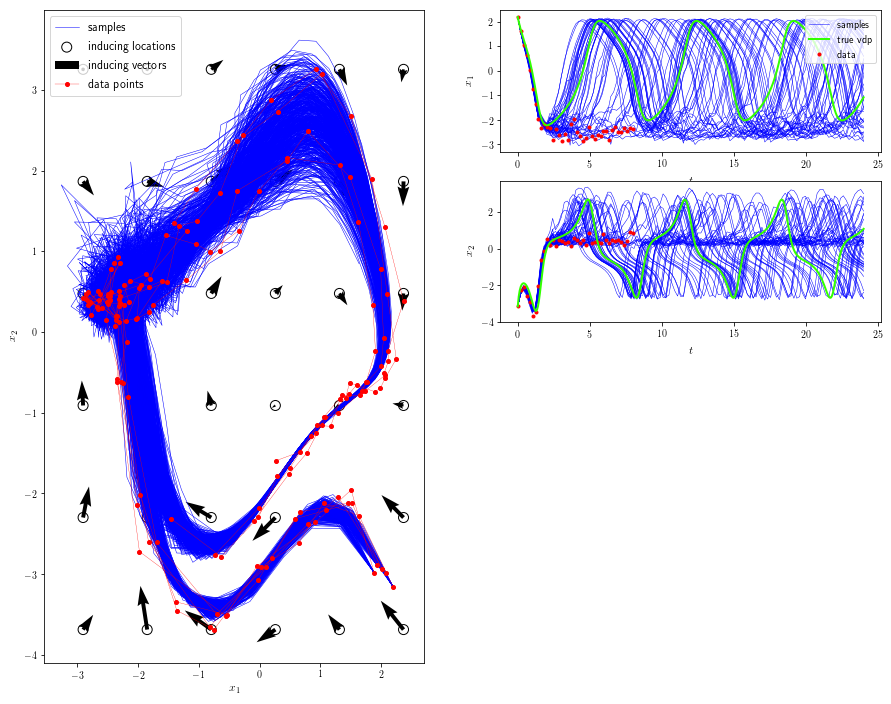

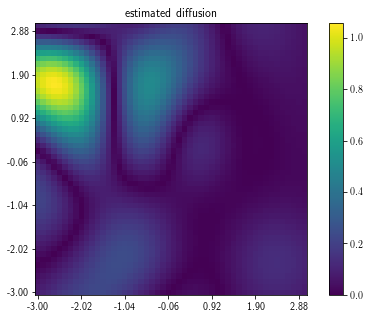

In [9]:
npde = npde_fit(sess, t, Y, model='sde', sf0=1.0, ell0=[1.0,1.0], ellg0=[1.0], W=6, ktype="id", 
                fix_Z=True, Nw=200, num_iter=500, print_int=100, eta=0.01, plot_=True)